In [ ]:
# default_exp search

# Search

> Functions related to the search

This notebook contains all functions related to the searching and getting peptide-spectrum-matches (PSMS).

Current ToDo here:

- Most of the functions are not very well described yet
- A key ingredient of speed is the frag_hits matrix to store the results which should be described
- Introductory text to give an overview would be nice.


In [ ]:
#hide
import warnings
from numba import NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

## Comparing Fragments

To efficiently compare two fragments, we use a pointer based approach. We start with two sorted arrays, the `query_frag` that contains the m/z positions of the query spectrum and the `db_frag` which contains the database fragment that is compared against to. The two pointers compare each m/z position with each other and check wheter they are within a certain tolerance `mtol`. Depending on their delta, either of the pointers is advanced. The function returns an arrray named `hits` that is the same length as the database spectrum and encodes the hit positions.

In [ ]:
#export
from numba import njit
import numpy as np

@njit(nogil=True)
def compare_frags(query_frag, db_frag, mtol, ppm=False):
    """
    Compare query and database frags and find hits
    """
    q_max = len(query_frag)
    d_max = len(db_frag)
    hits = np.zeros(d_max, dtype=np.int16)
    q, d = 0, 0  # q > query, d > database
    while q < q_max and d < d_max:
        mass1 = query_frag[q]
        mass2 = db_frag[d]
        delta_mass = mass1 - mass2

        if ppm:
            sum_mass = mass1 + mass2
            mass_difference = 2 * delta_mass / sum_mass * 1e6
        else:
            mass_difference = delta_mass

        if abs(mass_difference) <= mtol:
            hits[d] = q + 1  # Save query position +1 (zero-indexing)
            d += 1
            q += 1  # Only one query for each db element
        elif delta_mass < 0:
            q += 1
        elif delta_mass > 0:
            d += 1

    return hits

In [ ]:
import numpy as np
query_frag = np.array([100, 200, 300, 400])
db_frag = np.array([150, 200, 300, 450])

# Hits: Query 2 -> Db 2 and Query 3 -> Db 3

compare_frags(query_frag, db_frag, mtol=1)

array([0, 2, 3, 0], dtype=int16)

In [ ]:
#hide
def test_compare_frags():
    query_frag = np.array([100, 200, 300, 400])
    mtol = 1

    db_frag = query_frag.copy()

    # Self-Comparison: no of hits should be same as length
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: above but in tolerance
    hits = compare_frags(query_frag, db_frag + mtol - 0.01, mtol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: below but in tolerance
    hits = compare_frags(query_frag, db_frag - mtol + 0.01, mtol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: above tolerance, no hits
    hits = compare_frags(query_frag, db_frag + mtol + 0.01, mtol, ppm=False)
    assert np.sum(hits > 0) == 0

    # Special case 1: First and last
    db_frag = np.array([100, 400])
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == 2

    # Special case 2: Two queries matching the same DB frag
    query_frag = np.array([100, 100.5])
    db_frag = np.array([100, 200, 300])
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == 1

    # Special case 3: Two db frags matching the same query frag
    db_frag = np.array([100, 100.5])
    query_frag = np.array([100, 200, 300])
    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert np.sum(hits > 0) == 1
    
test_compare_frags()

This function allows us to easily compare a query spectrum against a theoretical database.

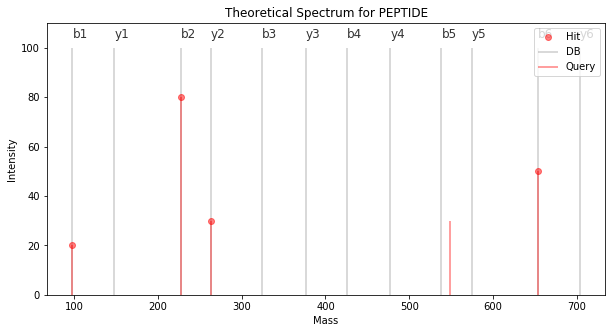

In [ ]:
import matplotlib.pyplot as plt
from alphapept import constants
from alphapept.fasta import get_frag_dict, parse
import numpy as np

%matplotlib inline
peptide = 'PEPTIDE'

# Theoretical Spectrum

frag_dict = get_frag_dict(parse(peptide), constants.mass_dict)
db_frag = list(frag_dict.values())
db_frag.sort()

db_int = [100 for _ in db_frag]

# Experimental Spectrum, dummy data

query_frag = np.array([98.06, 227.10, 263.08, 548.06, 653.31])
query_int = np.array([20, 80, 30, 30, 50])

hits = compare_frags(query_frag, db_frag, mtol=1)

hitpos = hits[hits > 0] - 1
hit_x = query_frag[hitpos]
hit_y = query_int[hitpos]


plt.figure(figsize=(10,5))
plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)
plt.vlines(query_frag, 0, query_int, "r", label="Query", alpha=0.5)

plt.plot(hit_x, hit_y, "ro", label="Hit", alpha=0.5)

for _ in frag_dict.keys():
    plt.text(frag_dict[_], 104, _, fontsize=12, alpha = 0.8)
    
plt.title('Theoretical Spectrum for {}'.format(peptide))
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.legend()
plt.ylim([0,110])
plt.show()

## Comparing Spectra

To compare multiple spectra against a database, we first need some helper functions. Per default, AlphaPept calculates in Dalton. To use ppm boundaries, we need the function `ppm_to_dalton` for conversion. 

To minimize the search space, we typically only compare spectra with precursors in the same mass range as defined by `m_offset`. To look up the limits for search, we define the function `get_idxs`, which is a wrapper to the fast `searchsorted` method from NumPy.

The actual search takes place in `compare_specs_single` and `compare_specs_parallel`, a single-core and multicore method for comparing spectra.

In [ ]:
#export
from numba import prange
@njit
def ppm_to_dalton(mass, m_offset):
    """

    """
    return mass / 1e6 * m_offset


def get_idxs(db_masses, query_masses, m_offset, ppm):
    """
    Function to get upper and lower limits to define search range.

    """
    if ppm:
        dalton_offset = ppm_to_dalton(query_masses, m_offset)
    else:
        dalton_offset = m_offset

    idxs_lower = db_masses.searchsorted(query_masses - dalton_offset, side="left")
    idxs_higher = db_masses.searchsorted(query_masses + dalton_offset, side="right")

    return idxs_lower, idxs_higher

@njit(parallel=True)
def compare_specs_parallel(
    frag_hits,
    query_masses,
    query_frags,
    db_masses,
    db_frags,
    idxs_lower,
    idxs_higher,
    mtol,
    query_bounds,
    db_bounds,
    chunk=(0, 1),
    offset=False,
    ppm=False,
):
    """
    Compare spectra, parallelized version
    """
    num_specs_compared = 0
    if chunk == (0, 0):
        for query_idx in prange(len(query_masses)):
            for db_idx in range(idxs_lower[query_idx] , idxs_higher[query_idx] ):
                num_specs_compared += 1
                query_frag = query_frags[:, query_idx] [: query_bounds[query_idx] ]
                db_frag = db_frags[:, db_idx] [: db_bounds[db_idx] ]
                o_mass = query_masses[query_idx]  - db_masses[db_idx]
                hits = compare_frags(query_frag, db_frag, mtol, ppm)
                if offset is True:  # Mirrored search
                    hits += compare_frags(query_frag, db_frag + o_mass, mtol, ppm)
                frag_hits[query_idx, db_idx - idxs_lower[query_idx] ] = np.sum(hits > 0)
    else:
        # Chunked version
        current_index = chunk[0]
        n_chunks = chunk[1]
        m_subset = np.arange(len(query_masses))[current_index::n_chunks]

        for index in prange(len(m_subset)):
            query_idx = m_subset[index]
            for db_idx in range(idxs_lower[query_idx] , idxs_higher[query_idx] ):
                num_specs_compared += 1
                query_frag = query_frags[:, query_idx] [: query_bounds[query_idx] ]
                db_frag = db_frags[:, db_idx] [: db_bounds[db_idx] ]
                o_mass = query_masses[query_idx]  - db_masses[db_idx]
                hits = compare_frags(query_frag, db_frag, mtol, ppm)
                if offset is True:  # Mirrored search
                    hits += compare_frags(query_frag, db_frag + o_mass, mtol, ppm)
                frag_hits[query_idx, db_idx - idxs_lower[query_idx] ] = np.sum(hits > 0)

    return frag_hits, num_specs_compared


@njit
def compare_specs_single(
    frag_hits,
    query_masses,
    query_frags,
    db_masses,
    db_frags,
    idxs_lower,
    idxs_higher,
    mtol,
    query_bounds,
    db_bounds,
    chunk=(0, 1),
    offset=False,
    ppm=False,
):
    """
    Compare spectra, single core version

    """
    num_specs_compared = 0

    if chunk == (0, 0):
        for query_idx in range(len(query_masses)):
            for db_idx in range(idxs_lower[query_idx] , idxs_higher[query_idx] ):
                num_specs_compared += 1
                query_frag = query_frags[:, query_idx] [: query_bounds[query_idx] ]
                db_frag = db_frags[:, db_idx] [: db_bounds[db_idx] ]
                o_mass = query_masses[query_idx]  - db_masses[db_idx]
                hits = compare_frags(query_frag, db_frag, mtol, ppm)
                if offset is True:  # Mirrored search
                    hits += compare_frags(query_frag, db_frag + o_mass, mtol, ppm)
                frag_hits[query_idx, db_idx - idxs_lower[query_idx] ] = np.sum(hits > 0)
    else:
        # Chunked version
        current_index = chunk[0]
        n_chunks = chunk[1]

        m_subset = np.arange(len(query_masses))[current_index::n_chunks]

        for index in range(len(m_subset)):
            query_idx = m_subset[index]
            for db_idx in range(idxs_lower[query_idx] , idxs_higher[query_idx] ):
                num_specs_compared += 1
                query_frag = query_frags[:, query_idx] [: query_bounds[query_idx] ]
                db_frag = db_frags[:, db_idx] [: db_bounds[db_idx] ]
                o_mass = query_masses[query_idx]  - db_masses[db_idx]
                hits = compare_frags(query_frag, db_frag, mtol, ppm)
                if offset is True:  # Mirrored search
                    hits += compare_frags(query_frag, db_frag + o_mass, mtol, ppm)
                frag_hits[query_idx, db_idx - idxs_lower[query_idx] ] = np.sum(hits > 0)

    return frag_hits, num_specs_compared

## Wrapper

In [ ]:
#export

import pandas as pd

def query_data_to_features(query_data):

    # if we dont use the feature finder we extract them from the query data..

    query_masses = query_data['prec_mass_list2']
    query_mz = query_data['mono_mzs2']
    query_rt = query_data['rt_list_ms2']

    features = pd.DataFrame(np.array([query_masses, query_mz, query_rt]).T, columns = ['mass_matched', 'mz_matched', 'rt_matched'])

    features['feature_idx'] = features.index #Index to query_data
    features['query_idx']  = np.arange(len(query_masses))

    features = features.sort_values('mass_matched', ascending=True)

    return features



def get_psms(
    query_data,
    db_data,
    features,
    parallel,
    m_tol,
    m_offset,
    ppm,
    min_frag_hits,
    callback = None,
    m_offset_calibrated = None,
    **kwargs
):
    """
    Wrapper function to extract psms from dataset

    Args:
        db_masses: database precursor masses
        query_masses: query precursor masses
        m_offset: mass offset in dalton or ppm
        ppm: flag for ppm or dalton
        callback: Callback function, e.g. for progress bar
    Returns:
        idxs_lower: lower search range
        idxs_higher: upper search range
    Raises:
    """
    
    if m_offset_calibrated:
        m_offset = m_offset_calibrated

    query_masses = query_data['prec_mass_list2']
    query_mz = query_data['mono_mzs2']
    query_frags = query_data['mass_list_ms2']
    query_bounds = query_data['bounds']
    query_rt = query_data['rt_list_ms2']
    db_masses = db_data['precursors']
    db_frags = db_data['fragmasses']
    db_bounds = db_data['bounds']


    if features is not None:
        query_masses = features['mass_matched'].values
        query_mz = features['mz_matched'].values
        query_rt = features['rt_matched'].values
        query_frags = query_frags[:, features['query_idx'].values]
        query_bounds = query_bounds[features['query_idx'].values]
    else:
        pass

    idxs_lower, idxs_higher = get_idxs(db_masses, query_masses, m_offset, ppm)
    frag_hits = np.zeros(
        (len(query_masses), np.max(idxs_higher - idxs_lower)), dtype=int
    )

    if callback is None:
        chunk = (0, 0)
        offset = False

        if parallel:
            frag_hits, num_specs_compared = compare_specs_parallel(
                frag_hits,
                query_masses,
                query_frags,
                db_masses,
                db_frags,
                idxs_lower,
                idxs_higher,
                m_tol,
                query_bounds,
                db_bounds,
                chunk,
                offset,
                ppm,
            )
        else:
            frag_hits, num_specs_compared = compare_specs_single(
                frag_hits,
                query_masses,
                query_frags,
                db_masses,
                db_frags,
                idxs_lower,
                idxs_higher,
                m_tol,
                query_bounds,
                db_bounds,
                chunk,
                offset,
                ppm,
            )

    else: #chunk the data for progess bar until numba has proper progress bar
        n_chunks = 100
        num_specs_compared = 0

        for current_chunk in range(n_chunks):
            chunk = (current_chunk, n_chunks)
            offset = False
            if parallel:
                frag_hits, num_specs_compared_chunk = compare_specs_parallel(
                    frag_hits,
                    query_masses,
                    query_frags,
                    db_masses,
                    db_frags,
                    idxs_lower,
                    idxs_higher,
                    m_tol,
                    query_bounds,
                    db_bounds,
                    chunk,
                    offset,
                    ppm,
                )
            else:
                frag_hits, num_specs_compared_chunk = compare_specs_single(
                    frag_hits,
                    query_masses,
                    query_frags,
                    db_masses,
                    db_frags,
                    idxs_lower,
                    idxs_higher,
                    m_tol,
                    query_bounds,
                    db_bounds,
                    chunk,
                    offset,
                    ppm,
                )

            if callback is not None:
                callback((current_chunk+1)/n_chunks)
            num_specs_compared += num_specs_compared_chunk

    hit_query, hit_db = np.where(frag_hits >= min_frag_hits)
    hits = frag_hits[hit_query, hit_db]
    hit_db += idxs_lower[hit_query]

    psms = np.array(
        list(zip(hit_query, hit_db, hits)), dtype=[("query_idx", int), ("db_idx", int), ("hits", int)]
    )

    return psms, num_specs_compared

## Extracting columns for scoring

### Frag Delta

In [ ]:
#export
@njit
def frag_delta(query_frag, db_frag, hits):
    """
    Calculate the mass difference for a given array of hits in Dalton and ppm
    """

    delta_m = db_frag[hits > 0] - query_frag[hits[hits > 0] - 1]
    delta_m_ppm = (
        2 * delta_m / (db_frag[hits > 0] + query_frag[hits[hits > 0] - 1]) * 1e6
    )

    return delta_m, delta_m_ppm

In [ ]:
#hide
def test_frag_delta():
    mtol = 10
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([101, 202, 303, 404])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    delta_m, delta_m_ppm = frag_delta(query_frag, db_frag, hits)

    assert np.sum(delta_m) == 10
    
test_frag_delta()

### Intensity Fraction

In [ ]:
#export
@njit
def intensity_fraction(query_int, hits):
    """
    Calculate the fraction of matched intensity
    """
    total_intensity = np.sum(query_int)
    if total_intensity != 0:
        matched_intensity = np.sum(query_int[hits[hits > 0] - 1])
        i_frac = matched_intensity / total_intensity
    else:
        i_frac = 0

    return i_frac

In [ ]:
#hide
def test_intensity_fraction():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    i_frac = intensity_fraction(query_int, hits)

    assert i_frac == 40 / 100

test_intensity_fraction()

### Intensity Product

In [ ]:
#export
@njit
def intensity_product(query_int, hits, db_int=None):
    """
    Calculate the dot product of matched query intensity to db intensity
    """

    matched_query_int = query_int[hits[hits > 0] - 1]
    if db_int is None:
        matched_intensity = np.sum(matched_query_int)
    else:
        matched_db_int = db_int[hits > 0]
        matched_intensity = np.sum(matched_query_int*matched_db_int)

    return matched_intensity

In [ ]:
#hide
def test_intensity_product():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert intensity_product(query_int, hits) == 40

    query_frag = np.array([100, 200, 300, 400, 600])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40, 50])
    db_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    assert intensity_product(query_int, hits, db_int = db_int) == 10*10+30*20
    
test_intensity_product()

### Mass desnity scores

The following functions are used to calculate scores that take the relative abundance of fragment ion masses in the database into account. The underlying hypothesis is that matched ions in less populated m/z regions are worth more that ions matched in highly populated m/z regions. 

The `get_frag_mass_density_norm` takes fragment ion masses `frags` as input and creates both an array of m/z bins and the respective negaive m/z density values. The `mz_factor` determines the m/z bin-width. A factor of 0.5 results in m/z bins of 20 Da, while a factor of 10 results in m/z bins of 0.1 Da. 

The score calculated by `mass_density_weighted_fragment_sum` corresponds to the sum of fragment ion hits weighted by the negative mass density. A fragment ion match in a sparsely populated m/z region therefor counts nearly 1, while a match in a densely populated region contributes with a low weight, e.g. 0.1.

The score calculated by `mass_density_weighted_intensity_sum` corresponds to a matched intensity score weighted by the negative mass density.

In [ ]:
#export 
@njit
def get_frag_mass_density_norm(frags, mz_factor=0.05): 
    frags_f = frags.flatten()
    frags_f_p = frags_f[frags_f >= 0]
    frags_f_p = (frags_f_p*mz_factor).astype(np.int64)
    mz_space = np.arange(0,np.max(frags_f_p)+1,1)/mz_factor
    mz_count = np.bincount(frags_f_p)
    
    if np.percentile(mz_count,90) > 0:
        if np.max(mz_count)/np.percentile(mz_count,90) > 50:
            mz_count_norm = np.zeros(len(mz_count))
            for i in prange(len(mz_count)):
                if mz_count[i] > 0:
                    mz_count_norm[i] = np.log(mz_count[i])
                else:
                    mz_count_norm[i] = 0
            max_int = np.max(mz_count_norm)
            mz_count_norm = mz_count_norm/max_int
        else:
            max_int = np.max(mz_count)
            mz_count_norm = mz_count/max_int
    else:
        max_int = np.max(mz_count)
        mz_count_norm = mz_count/max_int

    percentile_range = np.arange(0,0.9,0.1)
    mz_percentiles = np.searchsorted(percentile_range, mz_count_norm, side='left')

    neg_mz_density = np.zeros(len(mz_space))
    for i in prange(len(mz_space)):
        neg_mz_density[i] = (10-mz_percentiles[i])/10
    
    return neg_mz_density, mz_space

@njit
def mass_density_weighted_fragment_sum(query_frag, hits, mz_space, mz_density, mz_factor=0.05):
    matched_query_frag = query_frag[hits[hits > 0]-1]
    matched_query_frag_bin = (matched_query_frag*mz_factor).astype(np.int64)
    
    matched_query_frag_density = np.zeros(len(matched_query_frag_bin))
    for i in prange(len(matched_query_frag_bin)): 
        matched_query_frag_density[i] = mz_density[matched_query_frag_bin[i]]
    return np.sum(matched_query_frag_density)

@njit
def mass_density_weighted_intensity_sum(query_int, query_frag, hits, mz_space, mz_density, mz_factor=0.05):
    matched_query_frag = query_frag[hits[hits > 0]-1]
    matched_query_frag_bin = (matched_query_frag*mz_factor).astype(np.int64)
    
    matched_query_frag_density = np.zeros(len(matched_query_frag_bin))
    for i in prange(len(matched_query_frag_bin)): 
        matched_query_frag_density[i] = mz_density[matched_query_frag_bin[i]]
    
    matched_query_int = query_int[hits[hits > 0] - 1]
    
    if len(matched_query_frag_density) > 0:
        weighted_intensity_sum = np.sum(matched_query_int*matched_query_frag_density)
        if weighted_intensity_sum!=0:
            weighted_intensity_sum = np.log(weighted_intensity_sum)
        else:
            weighted_intensity_sum = 0
    else:
        weighted_intensity_sum = 0

    return weighted_intensity_sum

In [ ]:
#hide
def test_get_frag_mass_density_norm():
    db_frags = np.array([-1, 10, 20, 100, 110, -1])

    neg_mz_density, mz_space = get_frag_mass_density_norm(db_frags, mz_factor=0.05)
    assert len(mz_space) == 6
    assert mz_space[0] == 0
    assert all(neg_mz_density == np.array([0.5, 0.5, 1. , 1. , 1. , 0.1]))

    neg_mz_density, mz_space = get_frag_mass_density_norm(db_frags, mz_factor=10)
    assert len(mz_space) == 1101
    assert mz_space[0] == 0
    assert all(neg_mz_density[0:5] == np.array([1., 1., 1., 1., 1.]))
    assert neg_mz_density[100] == 0.1

test_get_frag_mass_density_norm()
    
def test_mass_density_weighted_fragment_sum():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    db_frags = np.array([-1, 100, 200, 300, 400, -1])
    
    neg_mz_density, mz_space = get_frag_mass_density_norm(db_frags, mz_factor=0.05)
    assert mass_density_weighted_fragment_sum(query_frag, hits, mz_space, neg_mz_density, mz_factor=0.05) == 0.2

    neg_mz_density, mz_space = get_frag_mass_density_norm(db_frags, mz_factor=10)
    assert np.round(mass_density_weighted_fragment_sum(query_frag, hits, mz_space, neg_mz_density, mz_factor=10), decimals=3) == 0.2

test_mass_density_weighted_fragment_sum()

def test_mass_density_weighted_intensity_sum():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    db_frags = np.array([-1, 100, 200, 300, 400, -1])
    neg_mz_density, mz_space = get_frag_mass_density_norm(db_frags, mz_factor=0.05)
    assert np.round(mass_density_weighted_intensity_sum(query_int, query_frag, hits, mz_space, neg_mz_density, mz_factor=0.05), decimals=3) == 1.386
    
test_mass_density_weighted_intensity_sum()


### B & Y - Hits

In [ ]:
#export
@njit
def b_y_hits(frag_type, hits):
    """
    Count the number of b and y hits
    hits usually start with b-ions (0), then y-ions (1)
    """
    hits_index = hits > 0

    hit_types = frag_type[hits_index]

    b_hits = np.sum(hit_types == 0)
    y_hits = np.sum(hit_types == 1)

    return b_hits, y_hits

In [ ]:
#hide
def test_b_y_hits():
    # TODO: Write a test to make sure the by hits are correct..
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])
    frag_type = np.array([1, 0, 1, 0])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    b_hit, y_hit = b_y_hits(frag_type, hits)

    assert (b_hit) == 1
    assert (y_hit) == 1

    frag_type = np.array([1, 1, 1, 1])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    b_hit, y_hit = b_y_hits(frag_type, hits)

    assert (b_hit) == 0
    assert (y_hit) == 2

    frag_type = np.array([0, 0, 0, 0])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)

    b_hit, y_hit = b_y_hits(frag_type, hits)

    assert (b_hit) == 2
    assert (y_hit) == 0
    
test_b_y_hits()

In [ ]:
#export
@njit(parallel=True)
def score_parallel(
    psms,
    query_masses,
    query_frags,
    query_ints,
    db_masses,
    db_frags,
    frag_types,
    mtol,
    query_bounds,
    db_bounds,
    ppm,
    db_ints = None,
):

    """
    Extract values to calculate a score. Parallel version.

    """
    num_specs_scored = 0

    delta_m = np.zeros(len(psms))
    delta_m_ppm = np.zeros(len(psms))
    total_int = np.zeros(len(psms))
    matched_int = np.zeros(len(psms))
    o_mass = np.zeros(len(psms))
    o_mass_ppm = np.zeros(len(psms))
    b_hits = np.zeros(len(psms))
    y_hits = np.zeros(len(psms))
    db_mass_density = np.zeros(len(psms))
    db_weighted_mass_density = np.zeros(len(psms))
    db_mass_density_digit = np.zeros(len(psms))
    db_weighted_mass_density_digit = np.zeros(len(psms))
    
    db_mz_density_005, db_mz_space_005 = get_frag_mass_density_norm(db_frags, mz_factor=0.05)
    db_mz_density_10, db_mz_space_10 = get_frag_mass_density_norm(db_frags, mz_factor=10)

    for i in prange(len(psms)):
        query_idx = psms[i]["query_idx"]
        db_idx = psms[i]["db_idx"]
        query_frag = query_frags[:, query_idx] [: query_bounds[query_idx] ]
        query_int = query_ints[:, query_idx] [: query_bounds[query_idx] ]
        db_frag = db_frags[:, db_idx] [: db_bounds[db_idx] ]
        frag_type = frag_types[:, db_idx] [: db_bounds[db_idx] ]
        o_mass[i] = query_masses[query_idx]  - db_masses[db_idx]
        o_mass_ppm[i] = 2 * o_mass[i] / (query_masses[query_idx]  + db_masses[db_idx] ) * 1e6
        total_intensity = np.sum(query_int)
        hits = compare_frags(query_frag, db_frag, mtol, ppm)
        mass, mass_ppm = frag_delta(query_frag, db_frag, hits)
        delta_m[i] = np.mean(mass)
        delta_m_ppm[i] = np.mean(mass_ppm)
        total_int[i] = np.sum(query_int)
        if db_ints is None:
            db_int = None
        else:
            db_int = db_ints[:, db_idx] [: db_bounds[db_idx] ]
        matched_int[i] = intensity_product(query_int, hits, db_int)
        
        db_mass_density[i] = mass_density_weighted_fragment_sum(query_frag, hits, db_mz_space_005, db_mz_density_005, mz_factor=0.05)
        db_weighted_mass_density[i] = mass_density_weighted_intensity_sum(query_int, query_frag, hits, db_mz_space_005, db_mz_density_005, mz_factor=0.05)
        db_mass_density_digit[i] = mass_density_weighted_fragment_sum(query_frag, hits, db_mz_space_10, db_mz_density_10, mz_factor=10)
        db_weighted_mass_density_digit[i] = mass_density_weighted_intensity_sum(query_int, query_frag, hits, db_mz_space_10, db_mz_density_10, mz_factor=10)
        
        b_hit, y_hit = b_y_hits(frag_type, hits)
        y_hits[i] = y_hit
        b_hits[i] = b_hit
        num_specs_scored += 1

    return (
        delta_m,
        delta_m_ppm,
        o_mass,
        o_mass_ppm,
        total_int,
        matched_int,
        b_hits,
        y_hits,
        num_specs_scored,
        db_mass_density,
        db_weighted_mass_density,
        db_mass_density_digit,
        db_weighted_mass_density_digit,
    )


@njit
def score_single(
    psms,
    query_masses,
    query_frags,
    query_ints,
    db_masses,
    db_frags,
    frag_types,
    mtol,
    query_bounds,
    db_bounds,
    ppm,
    db_ints = None,
):
    """
    Extract values to calculate a score. Single core version.
    """
    num_specs_scored = 0

    delta_m = np.zeros(len(psms))
    delta_m_ppm = np.zeros(len(psms))
    total_int = np.zeros(len(psms))
    matched_int = np.zeros(len(psms))
    o_mass = np.zeros(len(psms))
    o_mass_ppm = np.zeros(len(psms))
    b_hits = np.zeros(len(psms))
    y_hits = np.zeros(len(psms))
    db_mass_density = np.zeros(len(psms))
    db_weighted_mass_density = np.zeros(len(psms))
    db_mass_density_digit = np.zeros(len(psms))
    db_weighted_mass_density_digit = np.zeros(len(psms))
    
    db_mz_density_005, db_mz_space_005 = get_frag_mass_density_norm(db_frags, mz_factor=0.05)
    db_mz_density_10, db_mz_space_10 = get_frag_mass_density_norm(db_frags, mz_factor=10)

    for i in range(len(psms)):
        query_idx = psms[i]["query_idx"]
        db_idx = psms[i]["db_idx"]
        query_frag = query_frags[:, query_idx] [: query_bounds[query_idx] ]
        query_int = query_ints[:, query_idx] [: query_bounds[query_idx] ]
        db_frag = db_frags[:, db_idx] [: db_bounds[db_idx] ]
        frag_type = frag_types[:, db_idx] [: db_bounds[db_idx] ]
        o_mass[i] = query_masses[query_idx]  - db_masses[db_idx]
        o_mass_ppm[i] = 2 * o_mass[i] / (query_masses[query_idx]  + db_masses[db_idx] ) * 1e6
        total_intensity = np.sum(query_int)
        hits = compare_frags(query_frag, db_frag, mtol, ppm)
        mass, mass_ppm = frag_delta(query_frag, db_frag, hits)
        delta_m[i] = np.mean(mass)
        delta_m_ppm[i] = np.mean(mass_ppm)
        total_int[i] = np.sum(query_int)
        if db_ints is None:
            db_int = None
        else:
            db_int = db_ints[:, db_idx] [: db_bounds[db_idx] ]
        matched_int[i] = intensity_product(query_int, hits, db_int)
        
        db_mass_density[i] = mass_density_weighted_fragment_sum(query_frag, hits, db_mz_space_005, db_mz_density_005, mz_factor=0.05)
        db_weighted_mass_density[i] = mass_density_weighted_intensity_sum(query_int, query_frag, hits, db_mz_space_005, db_mz_density_005, mz_factor=0.05)
        db_mass_density_digit[i] = mass_density_weighted_fragment_sum(query_frag, hits, db_mz_space_10, db_mz_density_10, mz_factor=10)
        db_weighted_mass_density_digit[i] = mass_density_weighted_intensity_sum(query_int, query_frag, hits, db_mz_space_10, db_mz_density_10, mz_factor=10)
        
        b_hit, y_hit = b_y_hits(frag_type, hits)
        y_hits[i] = y_hit
        b_hits[i] = b_hit
        num_specs_scored += 1

    return (
        delta_m,
        delta_m_ppm,
        o_mass,
        o_mass_ppm,
        total_int,
        matched_int,
        b_hits,
        y_hits,
        num_specs_scored,
        db_mass_density,
        db_weighted_mass_density,
        db_mass_density_digit,
        db_weighted_mass_density_digit,
    )

In [ ]:
### Extracting Score columns

In [ ]:
#export
from numpy.lib.recfunctions import append_fields, drop_fields


def add_column(recarray, column, name):
    """
    Function to add a column with given name to recarray
    """
    if hasattr(recarray, name):
        recarray = drop_fields(recarray, name, usemask=False, asrecarray=True)
    recarray = append_fields(
        recarray, name, column, dtypes=column.dtype, usemask=False, asrecarray=True
    )
    return recarray


def remove_column(recarray, name):
    """
    Function to remove a column from recarray
    """
    if hasattr(recarray, name):
        recarray = drop_fields(recarray, name, usemask=False, asrecarray=True)
    return recarray

In [ ]:
#export
def get_sequences(psms, db_seqs):
    """
    Get sequences to add them to a recarray
    """
    sequence_list = db_seqs[psms["db_idx"]]

    return sequence_list


def get_score_columns(
    psms,
    query_data,
    db_data,
    features,
    parallel,
    m_tol,
    m_offset,
    ppm,
    **kwargs
):

    query_masses = query_data['prec_mass_list2']
    query_frags = query_data['mass_list_ms2']
    query_ints = query_data['int_list_ms2']

    query_mz = query_data['mono_mzs2']
    query_charges = query_data['charge2']

    query_rt = query_data['rt_list_ms2']
    query_bounds = query_data['bounds']

    db_masses = db_data['precursors']
    db_frags = db_data['fragmasses']
    db_bounds = db_data['bounds']
    frag_types = db_data['fragtypes']

    db_seqs = db_data['seqs']

    if 'db_ints' in db_data.keys():
        db_ints = db_data['db_ints']
    else:
        db_ints = None

    if features is not None:
        query_masses = features['mass_matched'].values
        query_mz = features['mz_matched'].values
        query_rt = features['rt_matched'].values
        query_frags = query_frags[:, features['query_idx'].values]
        query_bounds = query_bounds[features['query_idx'].values]
        query_charges = query_charges[features['query_idx'].values]
        query_ints = query_ints[:, features['query_idx'].values]
    else:
        pass

    if parallel:
        delta_m, delta_m_ppm, o_mass, o_mass_ppm, total_int, matched_int, b_hits, y_hits, num_specs_scored, db_mass_density, db_weighted_mass_density, db_mass_density_digit, db_weighted_mass_density_digit = score_parallel(
            psms,
            query_masses,
            query_frags,
            query_ints,
            db_masses,
            db_frags,
            frag_types,
            m_tol,
            query_bounds,
            db_bounds,
            ppm,
            db_ints,
        )
    else:
        delta_m, delta_m_ppm, o_mass, o_mass_ppm, total_int, matched_int, b_hits, y_hits, num_specs_scored, db_mass_density, db_weighted_mass_density, db_mass_density_digit, db_weighted_mass_density_digit = score_single(
            psms,
            query_masses,
            query_frags,
            query_ints,
            db_masses,
            db_frags,
            frag_types,
            m_tol,
            query_bounds,
            db_bounds,
            ppm,
            db_ints,
        )

    psms = add_column(psms, delta_m, "delta_m")
    psms = add_column(psms, delta_m_ppm, "delta_m_ppm")
    psms = add_column(psms, total_int, "total_int")
    psms = add_column(psms, o_mass, "o_mass")
    psms = add_column(psms, o_mass_ppm, "o_mass_ppm")
    psms = add_column(psms, matched_int, "matched_int")
    psms = add_column(psms, b_hits, "b_hits")
    psms = add_column(psms, y_hits, "y_hits")
    
    psms = add_column(psms, db_mass_density, "db_mass_density")
    psms = add_column(psms, db_weighted_mass_density, "db_weighted_mass_density")
    psms = add_column(psms, db_mass_density_digit, "db_mass_density_digit")
    psms = add_column(psms, db_weighted_mass_density_digit, "db_weighted_mass_density_digit")

    rts = np.array(query_rt)[psms["query_idx"]]
    psms = add_column(psms, rts, 'rt')

    seqs = get_sequences(psms, db_seqs)
    psms = add_column(psms, seqs, "sequence")

    mass = np.array(query_masses)[psms["query_idx"]]
    mz = np.array(query_mz)[psms["query_idx"]]
    charge = np.array(query_charges)[psms["query_idx"]]

    psms = add_column(psms, mass, "mass")
    psms = add_column(psms, mz, "mz")
    psms = add_column(psms, charge, "charge")
    
    psms = add_column(psms, np.char.add(np.char.add(psms['sequence'],"_"), psms['charge'].astype(int).astype(str)), 'precursor')

    if features is not None:

        psms = add_column(psms, features.loc[psms['query_idx']]['feature_idx'].values, 'feature_idx')

        for key in ['int_sum','int_apex','rt_start','rt_apex','rt_end','fwhm']:
            if key in features.keys():
                psms = add_column(psms, features.loc[psms['query_idx']][key].values, key)

    return psms, num_specs_scored

## Plot

In [ ]:
#export

def plot_hit(
    df,
    index,
    db_bounds,
    db_frags,
    frag_types,
    query_bounds,
    query_frags,
    query_ints,
    ppm,
    m_tol,
    db_ints = None,
    **kwargs
):
    spectrum = df.iloc[index]

    sequence = spectrum["sequence"]

    db_idx = spectrum["db_idx"]
    query_idx = spectrum["query_idx"]

    intensity_fraction = spectrum["matched_int"] / spectrum["total_int"]

    db_bound = db_bounds[db_idx]
    db_frag = db_frags[:, db_idx] [:db_bound]
    if db_ints is not None:
        db_int = db_ints[:, db_idx] [:db_bound]
    else:
        db_int = np.ones(len(db_frag))

    db_int = db_int / np.max(db_int) * 100

    frag_type = frag_types[:, db_idx] [:db_bound]

    query_bound = query_bounds[query_idx]
    query_frag = query_frags[:, query_idx] [:query_bound]
    query_int = query_ints[:, query_idx] [:query_bound]

    query_int = query_int / np.max(query_int) * 100

    hits = compare_frags(query_frag, db_frag, m_tol, ppm)

    n_hits = np.sum(hits > 0)

    hitpos = hits[hits > 0] - 1

    hit_x = query_frag[hitpos]
    hit_y = query_int[hitpos]

    # create an axis
    ax = plt.figure(figsize=(10, 5))

    plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)

    plt.vlines(query_frag, 0, query_int, "r", label="Query", alpha=0.5)

    plt.plot(hit_x, hit_y, "ro", label="Hit", alpha=0.5)

    figure_title = "PSM Match for Spectra: {} - sequence {} \nHits {} - Intensity Fraction {:.2f} %".format(
        query_idx, sequence, n_hits, intensity_fraction * 100
    )
    plt.title(figure_title)

    plt.xlabel("Mass")
    plt.ylabel("Relative Intensity (%)")
    plt.ylim([0, 110])

    plt.legend()
    plt.show()

## Wrapper

In [ ]:
#export
def perform_search(query_files, db_masses, db_frags, db_bounds, db_seqs, frag_types, plot, **kwargs):
    """
    Function to search and score one or multiple MS runs by the X!Tandem approach.

    """
    if isinstance(query_files, str):
        kwargs['query_path'] = query_files
        psms_all = score_psms(db_masses, db_frags, db_bounds, db_seqs, frag_types, plot=plot, **kwargs)
        psms_all['filename'] = query_files
    elif isinstance(query_files, list):
        psms_all = []
        for file in query_files:
            kwargs['query_path'] = file
            psms = score_psms(db_masses, db_frags, db_bounds, db_seqs, frag_types, plot=plot, **kwargs)
            psms['filename'] = file
            psms_all.append(psms)
        psms_all = pd.concat(psms_all, ignore_index=True)
    else:
        raise Exception('query_files should be either a string or a list. The selected query_files argument is of type: {}'.format(type(query_files)))
    return psms_all

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_settings.ipynb.
Converted 13_runner.ipynb.
Converted index.ipynb.
